# Assessment of vancomycin vs. another antibiotic

In clinical practice, the pertinent question is often not "should I use vancomycin?", but rather "should I use vancomycin or this other antibiotic?". This notebook aims to quantify the risk of nephrotoxicity when using vancomycin over the other antibiotic.


## Definitions

* **drug on admission:** patient received medication order -12 to 12 hours upon admission to the ICU
* **baseline creatinine:** first creatinine value between -12 to 12 hours upon admission to the ICU
* **AKI:** following KDIGO guidelines using only creatinine, any instance of AKI between 2-7 days after their ICU admission.

KDIGO guidelines for AKI are: >= 50% change from baseline over 7 days, or absolute increase of 0.3 in creatinine over 48 hours.

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

from tqdm import tqdm_notebook as tqdm

# helper functions stored in local py file
import utils

# 1. Extract data and apply exclusions

For more detail on exclusions, see the main vancomycin analysis notebook.

In [2]:
# cohort with exclusions applied
co = pd.read_csv('data/cohort.csv.gz')

Below we summarize the initial population size and the exclusions resulting in the final population

In [3]:
# remove corrupt hospitals & admissions before 2005 before summarizing the cohort

# for some of the exclusions, we don't want to include them in the denominator
# mainly they are unrelated to actual patient case-mix
pre_exclude = ('exclude_corrupt_hospitals', 'exclude_before_2005')

for c in pre_exclude:
    co = co.loc[co[c]==0]

print('== EXCLUSIONS - TOTAL ==')
N = co.shape[0]
print(f'{N:6d} unique unit stays.')
for c in co.columns:
    if c in pre_exclude:
        continue

    if c.startswith('exclude_'):
        N = co[c].sum()
        mu = co[c].mean()*100.0
        print(f'  {N:6d} ({mu:4.1f}%) - {c}')
        
print('\n== EXCLUSIONS - SEQUENTIAL ==')
N = co.shape[0]
print(f'{N:7d} unique unit stays.')
idx = co['patientunitstayid'].notnull()
for c in co.columns:
    if c in pre_exclude:
        continue

    if c.startswith('exclude_'):
        # index patients removed by this exclusion
        idxRem = (co[c]==1)
        # calculate number of patients being removed, after applying prev excl
        N = (idx & idxRem).sum()
        mu = N/co.shape[0]*100.0
        idx = idx & (~idxRem)
        n_rem = idx.sum()
        
        print(f'- {N:5d} = {n_rem:6d} ({mu:4.1f}% removed) - {c}')
        
        
# create a cohort ID variable
co_id = set(co.loc[idx, 'patientunitstayid'])

== EXCLUSIONS - TOTAL ==
3089748 unique unit stays.
  438245 (14.2%) - exclude_sdu
  116797 ( 3.8%) - exclude_short_stay
  1833830 (59.4%) - exclude_non_ed_admit
  2115226 (68.5%) - exclude_secondary_stay
  1570462 (50.8%) - exclude_missing_apache
  484535 (15.7%) - exclude_no_med_interface
  111555 ( 3.6%) - exclude_dialysis_chronic
  299980 ( 9.7%) - exclude_dialysis_first_week
  513293 (16.6%) - exclude_cr_missing_baseline
  1192358 (38.6%) - exclude_cr_missing_followup

== EXCLUSIONS - SEQUENTIAL ==
3089748 unique unit stays.
- 438245 = 2651503 (14.2% removed) - exclude_sdu
- 80573 = 2570930 ( 2.6% removed) - exclude_short_stay
- 1409906 = 1161024 (45.6% removed) - exclude_non_ed_admit
- 255882 = 905142 ( 8.3% removed) - exclude_secondary_stay
- 280553 = 624589 ( 9.1% removed) - exclude_missing_apache
- 99260 = 525329 ( 3.2% removed) - exclude_no_med_interface
- 17496 = 507833 ( 0.6% removed) - exclude_dialysis_chronic
- 37922 = 469911 ( 1.2% removed) - exclude_dialysis_first_week


In [4]:
# covariates from APACHE table
dem = pd.read_csv('data/demographics.csv.gz')

# abx drug doses
va = pd.read_csv('data/vanco.csv.gz')
ce = pd.read_csv('data/cefepime.csv.gz')
zo = pd.read_csv('data/zosyn.csv.gz')
aki = pd.read_csv('data/aki.csv.gz')

# APACHE
apache = pd.read_csv('data/apache.csv.gz')

# convert apache predictions into numeric
apache['apache_prob'] = pd.to_numeric(apache['apache_prob'])

# sepsis/infection/organ failure
dx = pd.read_csv('data/sepsis_infection.csv.gz')

## Merge data

The antibiotic administration data extracted above has all administrations from time 0.
Thus, three dataframes need to be extracted before we can merge data:

1. Extract vanco_adm and vanco_wk
2. Extract cefepime_adm and cefepime_wk
3. Extract zosyn_adm and zosyn_wk

In [5]:
v_df = utils.extract_adm_and_wk(va, 'vanco')
c_df = utils.extract_adm_and_wk(ce, 'cefepime')
z_df = utils.extract_adm_and_wk(zo, 'zosyn')

v_df.head()

,vanco_adm,vanco_wk
patientunitstayid,,
9,1,0
15,1,1
20,1,1
21,0,0
23,1,1


In [6]:
pd.crosstab(v_df['vanco_adm'], v_df['vanco_wk'])

vanco_wk,0,1
vanco_adm,,
0,82717,156471
1,191855,173867


We have two variables here: `vanco_adm` and `vanco_wk`.

* `vanco_adm`: did the patient receive vancomycin on ICU admission
* `vanco_wk`: did the patient receive vancomycin at some time >= 48 hours after ICU admission

We require both to be true to filter to patients who were administered vancomycin on ICU admission for at least 48 hours.

Before we do that, we can get an idea of how often these drugs are administered to our cohort.

In [7]:
# density of *any* antibiotic administration over time
xi = np.arange(-12*60, 168*60, 1)
drugs_to_compare = [['vanco', va], ['cefepime', ce], ['zosyn', zo]]

co_id_sorted = list(co_id)
co_id_sorted.sort()

# dictionary mapping patientunitstayid to an index
ptid_to_idx = dict(zip(co_id_sorted, range(len(co_id_sorted))))

drug_administration = np.zeros([len(co_id_sorted), len(xi), len(drugs_to_compare)], dtype=bool)

d = 0
for drug, d_df in drugs_to_compare:
    print(f'{drug}...')
    
    # limit to our cohort
    d_df = d_df.loc[d_df['patientunitstayid'].isin(co_id)]
    
    for ptid, grp in tqdm(d_df.groupby('patientunitstayid'), total=d_df['patientunitstayid'].nunique()):
        drug_admit_pt = np.zeros(len(xi), dtype=bool)
        for i, row in grp.iterrows():
            start = row['drugstartoffset'] + xi[0]
            if pd.isnull(row['drugstopoffset']):
                stop = start + 60
            else:
                stop = int(row['drugstopoffset'] + xi[0])

            # ensure the start/stop index into xi correctly, and don't go outside the range
            start = min(max(start, 0), len(xi))
            stop = min(max(stop, 0), len(xi))
            
            drug_admit_pt[start:stop] = True

        # insert the drug administration into the final matrix
        i = ptid_to_idx[ptid]
        drug_administration[i, :, d] = drug_admit_pt
    d += 1

vanco...


/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



cefepime...



zosyn...


In [8]:
pt_in_icu = np.zeros([len(co_id), len(xi)], dtype=bool)

dem_tmp = dem.loc[dem['patientunitstayid'].isin(co_id)]

for i, row in tqdm(dem_tmp.iterrows(), total=dem_tmp.shape[0]):
    if row['unitdischargeoffset'] > xi[-1]:
        stop = len(xi)
    else:
        stop = max(row['unitdischargeoffset'] - xi[0], 0)
    
    # insert the drug administration into the final matrix
    i = ptid_to_idx[row['patientunitstayid']]
    pt_in_icu[i, 0:stop] = True    

/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


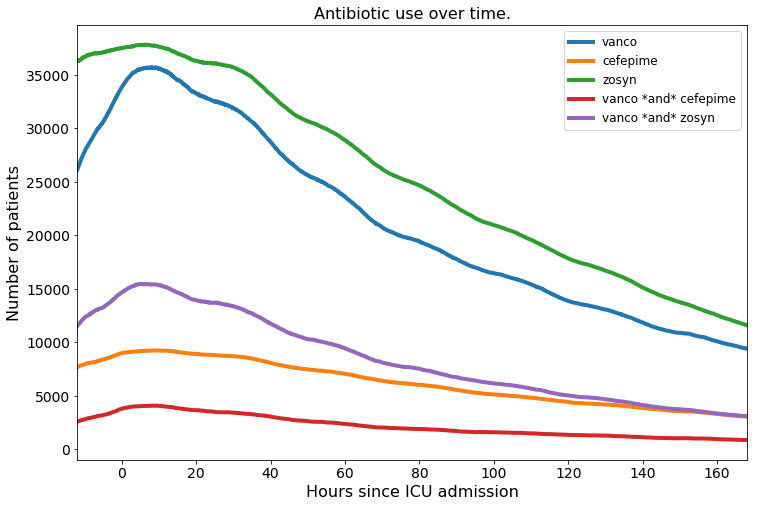

In [9]:
ax = plt.figure(figsize=[12, 8]).subplots()

for d, (drug, _) in enumerate(drugs_to_compare):
    d_administration = np.sum(drug_administration[:, :, d], 0)
    ax.plot(xi/60.0, d_administration, linewidth=4, label=drug)
    
# also plot combination - vanco & cefepime
for c in (1, 2):
    # vanco & ... blank.
    combo = np.sum(drug_administration[:, :, 0] & drug_administration[:, :, c], 0)
    ax.plot(xi/60.0, combo, linewidth=4, label=f'{drugs_to_compare[0][0]} *and* {drugs_to_compare[c][0]}')
    
ax.legend(fontsize=12)
ax.set_ylabel('Number of patients', fontsize=16)

# ax.fill_between(xi/60.0, 0, vanco_administration, 'b')
ax.set_xlim([-12, 168])
    

plt.title('Antibiotic use over time.', fontsize=16)
ax.set_xlabel('Hours since ICU admission', fontsize=16)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.show()

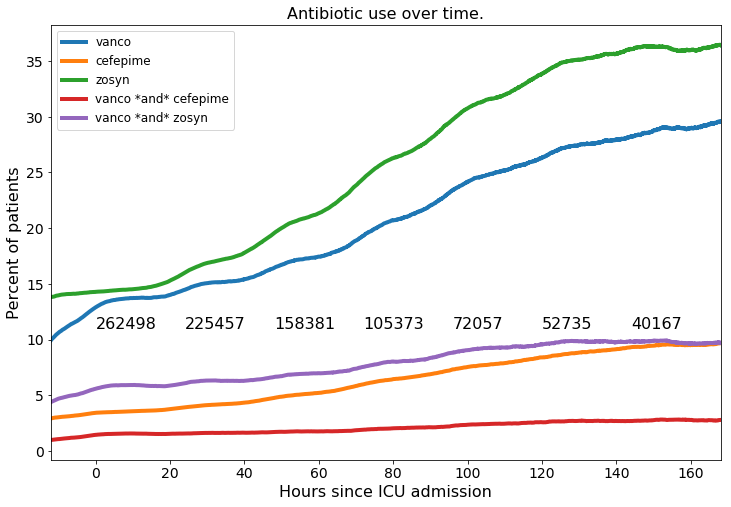

In [19]:
ax = plt.figure(figsize=[12, 8]).subplots()
n_pt_in_icu = np.sum(pt_in_icu, 0)
for d, (drug, _) in enumerate(drugs_to_compare):
    d_administration = 100.0 * np.sum(drug_administration[:, :, d], 0) / n_pt_in_icu
    ax.plot(xi/60.0, d_administration, linewidth=4, label=drug)
    
# also plot combination - vanco & cefepime
for c in (1, 2):
    # vanco & ... blank.
    combo = 100.0 * np.sum(drug_administration[:, :, 0] & drug_administration[:, :, c], 0) / n_pt_in_icu
    ax.plot(xi/60.0, combo, linewidth=4, label=f'{drugs_to_compare[0][0]} *and* {drugs_to_compare[c][0]}')
    
ax.legend(fontsize=12)
ax.set_ylabel('Percent of patients', fontsize=16)

# ax.fill_between(xi/60.0, 0, vanco_administration, 'b')
ax.set_xlim([-12, 168])

for t in range(0, 168, 24):
    # write text on graph of # of patients
    i = np.where(xi >= t*60.0)[0][0]
    plt.text(t, 11, f'{n_pt_in_icu[i]}', fontsize=16)

plt.title('Antibiotic use over time.', fontsize=16)
ax.set_xlabel('Hours since ICU admission', fontsize=16)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.show()

## Apply exclusions and create final dataframe

The `prepare_dataframe` function merges the data into a single dataframe, applying exclusions from `co` and subselecting certain variables.

In particular, this function will create a `vanco` column, which is equal to `(vanco_adm == 1) & (vanco_wk == 1)`.
Similarly it will create a `cefepime` and `zosyn` column

In [11]:
df = utils.prepare_dataframe(co, dem, aki, apache, dx, drug_dfs=[v_df, c_df, z_df])

print('{} patients.'.format(df.shape[0]))

print('Antibiotic use for 48 hours in the ICU:')
for abx in ['vanco', 'cefepime', 'zosyn']:
    N = df[abx].sum()
    mu = N/df.shape[0]*100.0
    print(f'  {N:5d} ({mu:4.1f}%) - {abx}')
    

print('\nConcurrent antibiotic use:')
for abx1, abx2 in [['vanco', 'cefepime'], ['vanco', 'zosyn']]:
    N = ((df[abx1] == 1) & (df[abx2] == 1)).sum()
    mu = N/df.shape[0]*100.0
    print(f'  {N:5d} ({mu:4.1f}%) - {abx1} & {abx2}')
    
df.head()

262498 patients.
Antibiotic use for 48 hours in the ICU:
  30694 (11.7%) - vanco
   7119 ( 2.7%) - cefepime
  31377 (12.0%) - zosyn

Concurrent antibiotic use:
   3208 ( 1.2%) - vanco & cefepime
  12718 ( 4.8%) - vanco & zosyn


,unitdischargeoffset,age,gender,ethnicity,weight_kg,height_cm,bmi,bmi_group,apachescore,apache_group,...,immunocompromised,sepsis_explicit,infection,organfailure,infection_skin_soft_tissue,sepsis,egfr,vanco,cefepime,zosyn
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141139,4332,50,Male,Caucasian,111.27,193.0,30.0,overweight,34.0,31-40,...,no,0,0,0,no,no,75.594581,0,0,0
141144,10014,65,Female,Caucasian,102.71,167.6,37.0,overweight,48.0,41-50,...,no,0,0,1,no,no,62.838338,0,0,0
141151,4313,67,Male,Caucasian,86.05,172.5,29.0,overweight,52.0,51-60,...,no,0,0,0,no,no,19.756316,0,0,0
141156,1189,90,Male,Caucasian,76.10,172.7,26.0,overweight,49.0,41-50,...,no,0,0,0,no,no,56.878962,0,0,0
141159,4595,61,Male,African American,63.91,170.2,22.0,normal,55.0,51-60,...,no,0,0,0,no,no,138.955446,0,0,0


# Primary analysis

We will compare two groups of patients: those who receive vancomycin and zosyn at the same time versus those who receive vancomycin and cefepime.

In order to make this comparison clear, we'll define all the groups upfront, then later run the comparison.

In [12]:
from collections import OrderedDict
comparisons = OrderedDict()

idxCefepime = df['cefepime'] == 1
idxZosyn = df['zosyn'] == 1
idxVanco = df['vanco'] == 1

# Vanco + Zosyn vs Vanco + Cefepime
idxE = idxVanco & idxZosyn & ~idxCefepime
idxC = idxVanco & ~idxZosyn & idxCefepime

# Vanco + Zosyn vs Vanco + Cefepime
comparison = {
    'exposure': df[idxE].copy(),
    'control': df[idxC].copy(),
    'covariates': [
        'age', 'apache_prob', 'sepsis', 'immunocompromised', 'egfr'
    ],
    'seed': 842
}

## Propensity score comparison

With the dataset defined, we can run the propensity score modeling followed by caliper matching to create two groups matched on the confounders.

In [13]:
m = utils.propensity_match(**comparison)

# calculate a contingency table for each "strata"
# here the strata are a match between a single patient in the minority group
# and 1 or more patients in the majority group
cm = utils.get_contingency_tables(m, outcome_var='aki')

# CMH tests for the significance of the odds ratio between matched pairs
pval, R, ci = utils.cmh_test(cm, alpha=0.05)
pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'

print('Result of propensity score followed by matching:')
print(f'p {pval_str}.\nOdds ratio: {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')

Column ethnicity missing 88 observations in exposure dataframe.
Column ethnicity missing 12 observations in control dataframe.
Column weight_kg missing 75 observations in exposure dataframe.
Column weight_kg missing 17 observations in control dataframe.
Column height_cm missing 222 observations in exposure dataframe.
Column height_cm missing 49 observations in control dataframe.
Column bmi missing 264 observations in exposure dataframe.
Column bmi missing 61 observations in control dataframe.
Column bmi_group missing 264 observations in exposure dataframe.
Column bmi_group missing 61 observations in control dataframe.


Formula:
status ~ age+apache_prob+immunocompromised+sepsis+egfr
n majority: 12632
n minority: 3122
Fitting 1 (Unbalanced) Model...

Accuracy 80.18
Result of propensity score followed by matching:
p < 0.001.
Odds ratio: 1.17 [1.07 - 1.28].


/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/pymatch/Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
/home/alistairewj/miniconda3/envs/vanco-renal-toxicity/lib/python3.7/site-packages/pymatch/Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index


## Subanalysis

We'd like to investigate whether subgrouping based off of eGFR at the time of ICU admission makes any difference.

In [14]:
def add_grouped_var(x: pd.Series, bins=[(0, 60)]):
    y = x.copy()
    bin_order = []
    for b in bins:
        idx = (x > b[0]) & (x <= b[1])
        bin_name = f'{b[0]} - {b[1]}'
        y.loc[idx] = bin_name
        bin_order.append(bin_name)


    idx = (x > b[1])
    bin_name = f'> {b[1]}'
    y.loc[idx] = bin_name
    bin_order.append(bin_name)
    
    return y, bin_order

## Subgroups of eGFR in other comparisons

In [15]:
seed_base = 1000
df_tmp = df.copy()
df_tmp['egfr_groups'], bin_order = add_grouped_var(df_tmp['egfr'])

i = 0

# this does *not* adjust for eGFR in the propensity score
egfr_ps, egfr_cm = {}, {}

# calculate odds ratio in each group
for b in bin_order:
    idx = df_tmp['egfr_groups'] == b
    df_cmp = df_tmp.loc[idx]

    idxCefepime = df_cmp['cefepime'] == 1
    idxZosyn = df_cmp['zosyn'] == 1
    idxVanco = df_cmp['vanco'] == 1

    # re-do the propensity scores
    # Vanco + Zosyn vs Vanco + Cefepime
    idxE = idxVanco & idxZosyn & ~idxCefepime
    idxC = idxVanco & ~idxZosyn & idxCefepime

    propensity_vars = {
        'exposure': df_cmp[idxE],
        'control': df_cmp[idxC],
        'covariates': [
            'age', 'apache_prob', 'sepsis', 'infection_skin_soft_tissue', 'immunocompromised'
        ],
        'seed': seed_base+i
    }

    egfr_ps[b] = utils.propensity_match(**propensity_vars)

    # get CMs
    egfr_cm[b] = utils.get_contingency_tables(egfr_ps[b], outcome_var='aki')

    i+=1

Column ethnicity missing 43 observations in exposure dataframe.
Column ethnicity missing 7 observations in control dataframe.
Column weight_kg missing 37 observations in exposure dataframe.
Column weight_kg missing 5 observations in control dataframe.
Column height_cm missing 84 observations in exposure dataframe.
Column height_cm missing 24 observations in control dataframe.
Column bmi missing 106 observations in exposure dataframe.
Column bmi missing 27 observations in control dataframe.
Column bmi_group missing 106 observations in exposure dataframe.
Column bmi_group missing 27 observations in control dataframe.


Formula:
status ~ age+apache_prob+immunocompromised+infection_skin_soft_tissue+sepsis
n majority: 5807
n minority: 1462
Fitting 1 (Unbalanced) Model...

Accuracy 79.89


Column ethnicity missing 45 observations in exposure dataframe.
Column ethnicity missing 5 observations in control dataframe.
Column weight_kg missing 38 observations in exposure dataframe.
Column weight_kg missing 12 observations in control dataframe.
Column height_cm missing 138 observations in exposure dataframe.
Column height_cm missing 25 observations in control dataframe.
Column bmi missing 158 observations in exposure dataframe.
Column bmi missing 34 observations in control dataframe.
Column bmi_group missing 158 observations in exposure dataframe.
Column bmi_group missing 34 observations in control dataframe.


Formula:
status ~ age+apache_prob+immunocompromised+infection_skin_soft_tissue+sepsis
n majority: 6825
n minority: 1660
Fitting 1 (Unbalanced) Model...

Accuracy 80.44


In [16]:
# below should be well balanced since we have eGFR in our confounders
#import seaborn as sns
#sns.catplot(x='egfr_groups', y="scores", hue="status", kind='box', order=bin_order, data=df_matched)

In [17]:
# print out final result
print('v+z (exp) vs v+c (ctl)')
for b in bin_order:
    m = egfr_ps[b]
    cm = egfr_cm[b]
    
    pval, R, ci = utils.cmh_test(cm, alpha=0.05)
    pval_str = f'= {pval:1.3f}' if pval > 0.001 else '< 0.001'
    
    n = m.matched_data['match_id'].nunique()
    idx = m.matched_data['status'] == 1
    n_exposed = m.matched_data.loc[idx]['record_id'].nunique()
    n_control = m.matched_data.loc[~idx]['record_id'].nunique()
    print(f'{b}: N={n} ({n_exposed} exp, {n_control} ctl). p {pval_str}. OR: {R:3.2f} [{ci[0]:3.2f} - {ci[1]:3.2f}].')

print('\n')

v+z (exp) vs v+c (ctl)
0 - 60: N=5807 (5807 exp, 1297 ctl). p = 0.402. OR: 1.06 [0.93 - 1.21].
> 60: N=6825 (6825 exp, 1476 ctl). p = 0.002. OR: 1.22 [1.07 - 1.38].




## Misc debugging

In [18]:
# determine the minority group
# this group will be matched to more than one case
idxMinority = df_matched[m.yvar] == m.minority

df_matched = df_matched.loc[idxMinority].merge(
    df_matched.loc[~idxMinority],
    how='inner',
    on='match_id',
    suffixes=('_minority', '_majority')
)

if m.minority == 1:
    print('Exposed group is minority.')
    df_matched.columns = [c.replace('_minority', '_exposed') for c in df_matched.columns]
    df_matched.columns = [c.replace('_majority', '_control') for c in df_matched.columns]
else:
    print('Exposed group is majority.')
    df_matched.columns = [c.replace('_majority', '_exposed') for c in df_matched.columns]
    df_matched.columns = [c.replace('_minority', '_control') for c in df_matched.columns]
    

df_matched.head()

NameError: name 'df_matched' is not defined